In [1]:
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)

df_results_matching_all = pd.read_parquet('did_matching.parquet')

In [2]:
def get_ATE(df, delta_ref, delta_ana, y):
    alpha=.05
    
    # Filter only the 2 Pre and Post Periods
    df2 = df[df.delta.isin([delta_ref, delta_ana])]
    # For the Post period select all the blocks
    # So now filter just the avalaible blocks
    sq_aval = df[df.delta.isin([delta_ana])].sq.unique()
    df2 = df2[df2.sq.isin(sq_aval)]
    # Apply the Time transformation
    df2['Y'] = df2.delta.apply(lambda x: 0 if x == delta_ref else 1)
    # The interaction
    df2['Y:T'] = df2['T'] * df2['Y']
    # Create the X and Y for regression
    df2 = df2[['sq', 'T', 'Y', 'Y:T', y]].drop_duplicates()
    X = df2[['T', 'Y', 'Y:T']].copy()
    Y = df2[y].copy()
    X['const'] = 1
    # Apply OLS
    res = sm.OLS(Y, X).fit()
    # Now we return the Lower and Upper bound and the coef into a DataFrame
    df_ci = res.conf_int(alpha=alpha)[res.conf_int(alpha=alpha).index=='Y:T']
    df_ci.columns = ["LB", "UB"]
    df_ci["coef"] = df_ci.mean(axis=1)
    return df_ci


def plot_did(df_plot, delta_ref):
    # Just the visuzalization from the get_ATE function
    x_b = list(df_plot[df_plot.year <= delta_ref].year.values)
    y_b = list(df_plot[df_plot.year <= delta_ref].coef.values)
    y_upper_b = list(df_plot[df_plot.year <= delta_ref].UB.values)
    y_lower_b = list(df_plot[df_plot.year <= delta_ref].LB.values)

    x_a = list(df_plot[df_plot.year >= delta_ref].year.values)
    y_a = list(df_plot[df_plot.year >= delta_ref].coef.values)
    y_upper_a = list(df_plot[df_plot.year >= delta_ref].UB.values)
    y_lower_a = list(df_plot[df_plot.year >= delta_ref].LB.values)

    fig = go.Figure([
        go.Scatter(
            x=x_b,
            y=y_b,
            line=dict(color='rgba(255, 102, 140,0.9)'),
            mode='lines',
            name='Before'
        ),
        go.Scatter(
            x=x_a,
            y=y_a,
            line=dict(color='rgba(102, 179, 255, 0.9)'),
            mode='lines',
            name='After'
        ),
        go.Scatter(
            x=x_b+x_b[::-1], # x, then x reversed
            y=y_upper_b+y_lower_b[::-1], # upper, then lower reversed
            fill='toself',
            fillcolor='rgba(255, 102, 140,0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False
        ),
        go.Scatter(
            x=x_a+x_a[::-1], # x, then x reversed
            y=y_upper_a+y_lower_a[::-1], # upper, then lower reversed
            fill='toself',
            fillcolor='rgba(102, 217, 255,0.2)',
            line=dict(color='rgba(255,255,255,0.1)'),
            hoverinfo="skip",
            showlegend=False,
    #         alpha=.2
        )
    ])
    fig.update_layout(
        title=y,
        xaxis_title="relative-to-treatment time (years)",
        yaxis_title="ATE (m²)"
    )
    fig.show()

In [198]:
# Preview some expected effects
df_results_matching_all[df_results_matching_all.delta.isin([-3, 6, 10])].groupby(['delta', 'T']).agg(
    {
        'per Area Residencial - H': 'mean', 'per Area Residencial - V': 'mean', 'per Area Comercial': 'mean', 'Terreno': 'mean',
        'Area Residencial - H': 'mean', 'Area Residencial - V': 'mean', 'Area Comercial': 'mean',
        'sum Area Residencial - H': 'mean', 'sum Area Residencial - V': 'mean', 'sum Area Comercial': 'mean',
        'CA': 'mean' , 'TO': 'mean'
    }
)

per Area Residencial - H  per Area Residencial - V  \
delta T                                                       
-3    0                  0.494431                  0.154493   
      1                  0.480775                  0.164047   
 6    0                  0.458644                  0.177833   
      1                  0.416876                  0.211787   
 10   0                  0.468826                  0.176354   
      1                  0.413427                  0.223064   

         per Area Comercial   Terreno  Area Residencial - H  \
delta T                                                       
-3    0            0.252669  0.041711           3388.915668   
      1            0.273777  0.044529           3217.690877   
 6    0            0.240491  0.035663           3684.217613   
      1            0.271275  0.051809           3217.901931   
 10   0            0.226606  0.031991           3817.997567   
      1            0.259817  0.053725           3219.452114   

         Area Residencial - V  Area Comercial  sum Area Residencial - H  \
delta T                                                                   
-3    0           5220.616866     3430.103168                196.917380   
      1           5412.775022     3730.842338                 75.204163   
 6    0           4961.049491     3630.890102                192.464338   
      1           6461.552124     4060.567568                 -2.002317   
 10   0           5077.615572     3375.996756                250.291971   
      1           6772.291631     3909.461605                -38.650561   

         sum Area Residencial - V  sum Area Comercial        CA        TO  
delta T                                                                    
-3    0               1910.153682         1233.505993  1.037066  0.507700  
      1               2055.882640         1108.889283  1.102270  0.512393  
 6    0               2366.828967         1487.156477  1.089205  0.522544  
      1               3410.040927         1378.924324  1.208871  0.517840  
 10   0               2794.974858         1407.107056  1.106154  0.531768  
      1               4059.996549         1464.735979  1.278497  0.519703

In [225]:
# Select the outcome

# y = 'sum Area Residencial - H'
# y = 'sum Area Residencial - V'
y = 'sum Area Comercial'
# y = 'CA'
# y = 'QUANTIDADE DE PAVIMENTOS'



df_results_matching_all[y].mean()

1054.956420694711

In [226]:
# Split the stations into two
# Central and wealthy group and the Periphrical Group
v_ref = 'VALOR DO M2 DO TERRENO'
metro_alta = df_results_matching_all.groupby('Nome')[v_ref].mean().sort_values(ascending=False).head(7).index
metro_baixa = df_results_matching_all.groupby('Nome')[v_ref].mean().sort_values(ascending=True).head(20).index
metro_alta = set(metro_alta) | set(['Brooklin', 'Vila Madalena'])


df_results_alta = df_results_matching_all[df_results_matching_all.Nome.isin(metro_alta)]
df_results_baixa = df_results_matching_all[df_results_matching_all.Nome.isin(metro_baixa)]

Geral


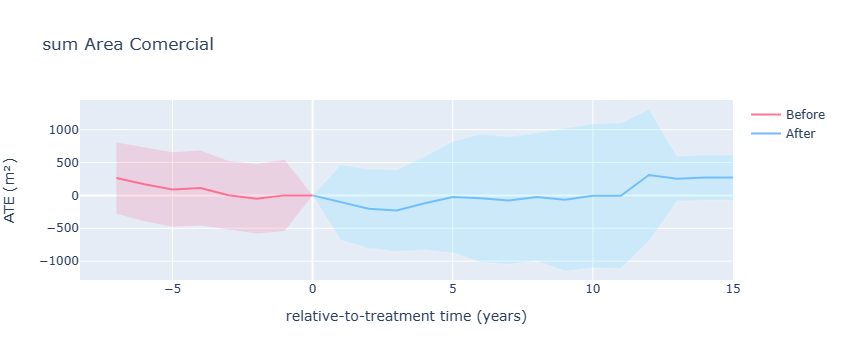

Baixa


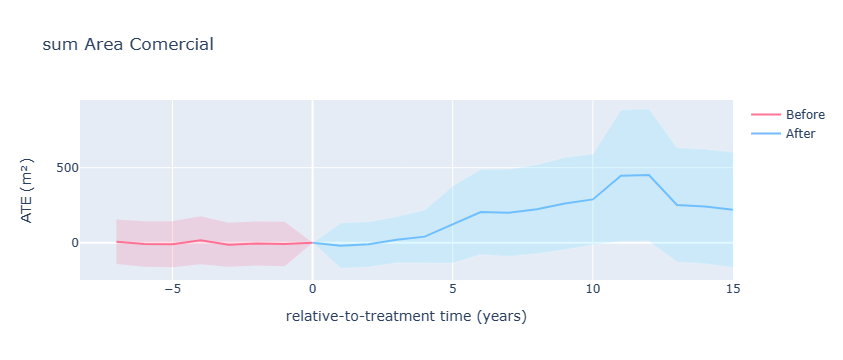

Alta


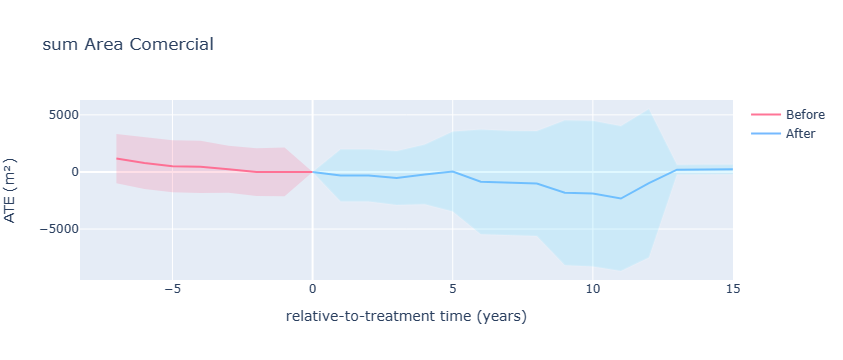

In [227]:
# Set the reference year
delta_ref = 0

lst_aux_ana = []
# For each year we apply the DID and append to a empty list
for year in range(-7, 16):
    lst_aux_ana.append(get_ATE(df_results_matching_all, delta_ref, year, y).assign(year=year))
# Convert the list into a unified Dataframe
df_plot = pd.concat(lst_aux_ana)
print('General')
# Now Plot the result
plot_did(df_plot, delta_ref)

# Same code, for another group
lst_aux_ana = []
for year in range(-7, 16):
    lst_aux_ana.append(get_ATE(df_results_baixa, delta_ref, year, y).assign(year=year))
df_plot = pd.concat(lst_aux_ana)
print('Peripherical Group')
plot_did(df_plot, delta_ref)

# Same...
lst_aux_ana = []
for year in range(-7,16):
    lst_aux_ana.append(get_ATE(df_results_alta, delta_ref, year, y).assign(year=year))
df_plot = pd.concat(lst_aux_ana)
print('Central Group')
plot_did(df_plot, delta_ref)

Vila das Belezas


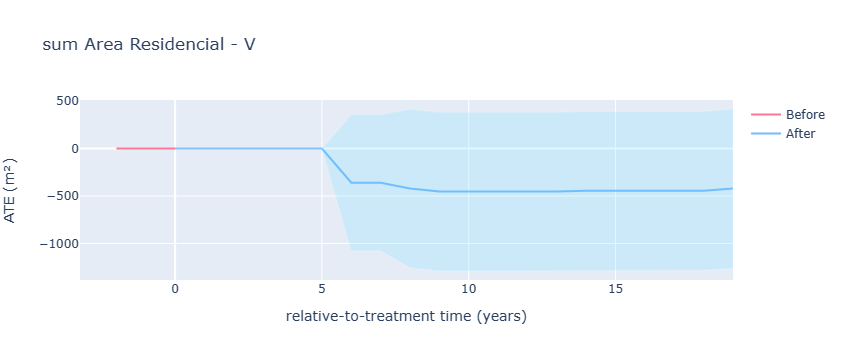

Vila União


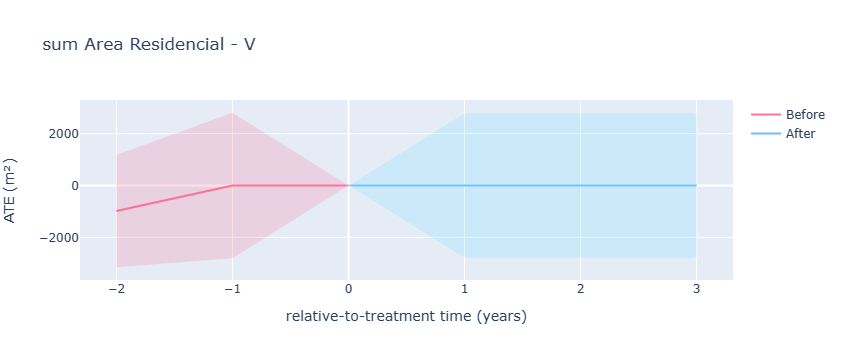

Vila Tolstói


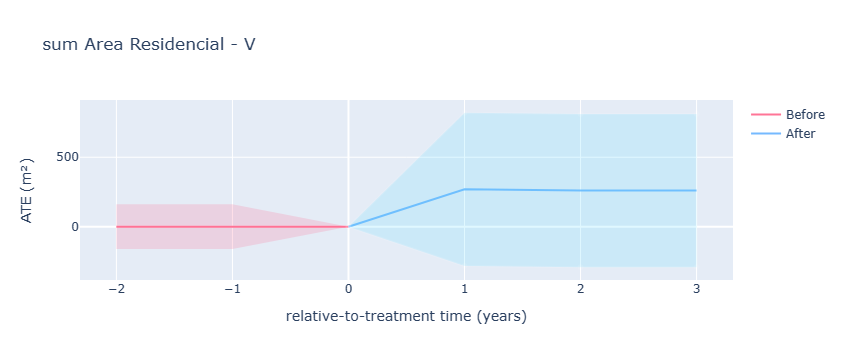

Vila Prudente


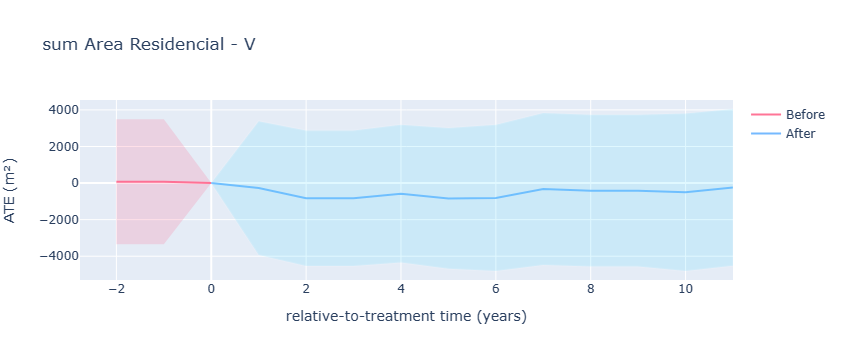

Vila Madalena


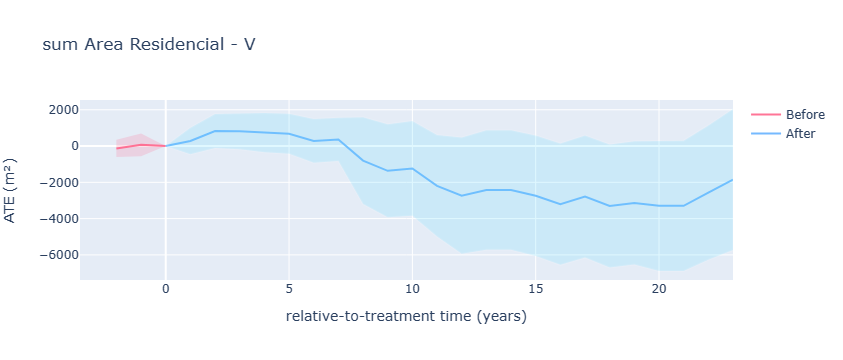

Tucuruvi


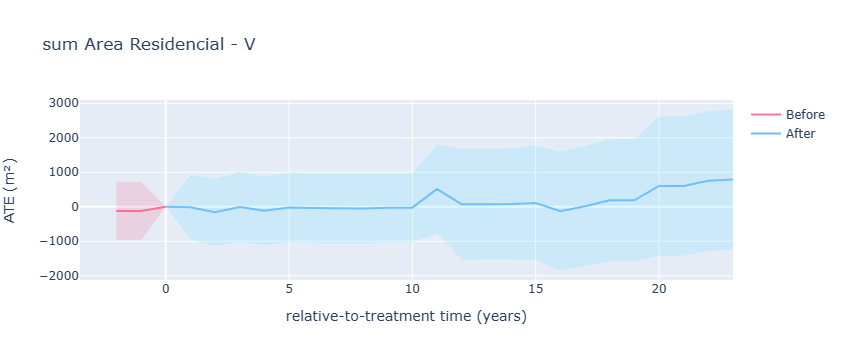

Tamanduateí


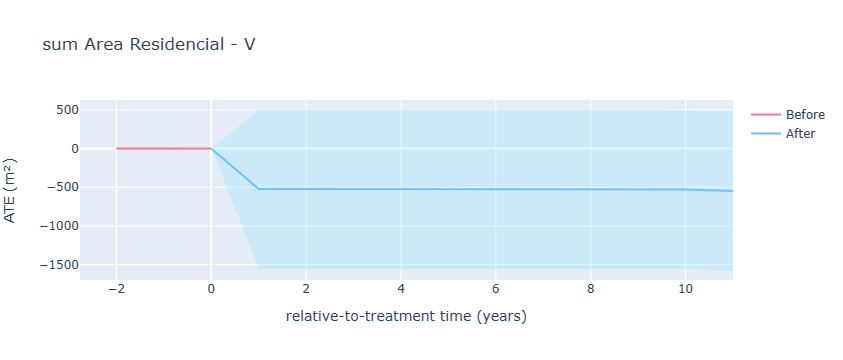

São Paulo-Morumbi


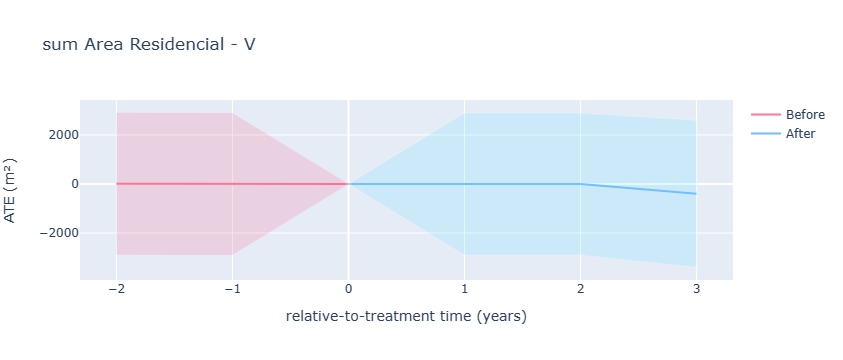

São Mateus


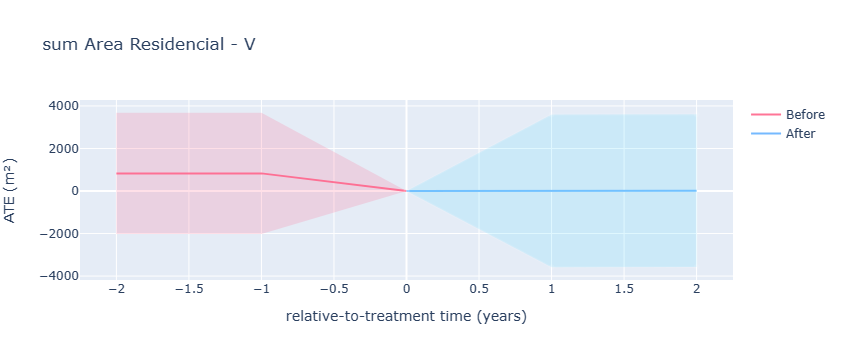

São Lucas


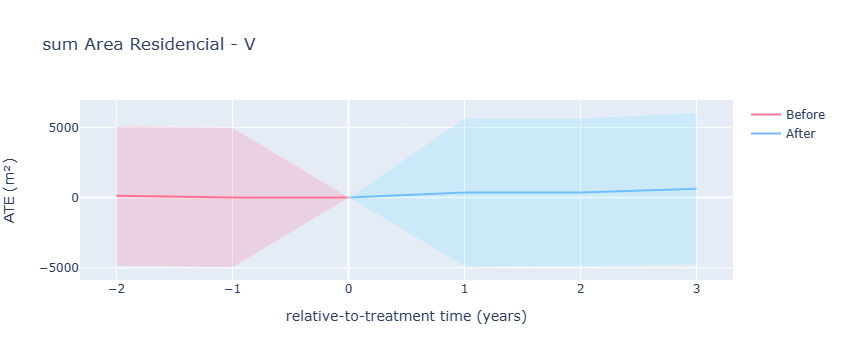

Sapopemba


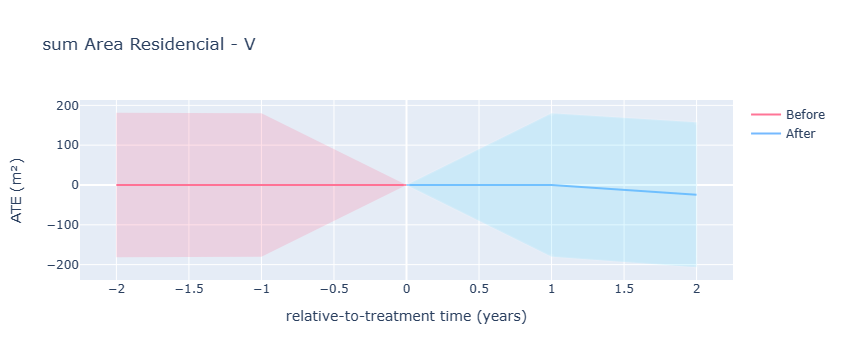

Santos-Imigrantes


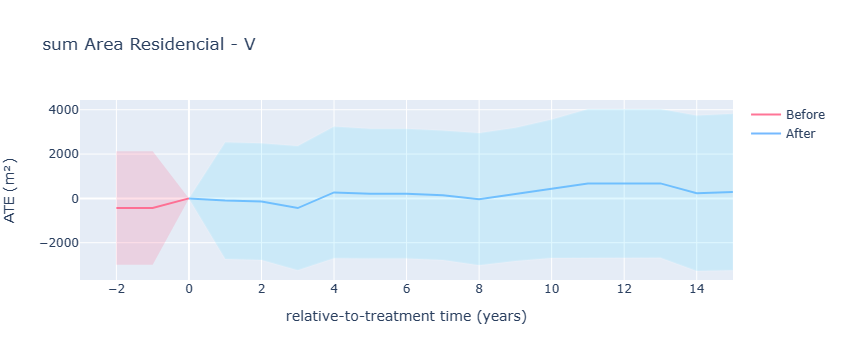

Santo Amaro


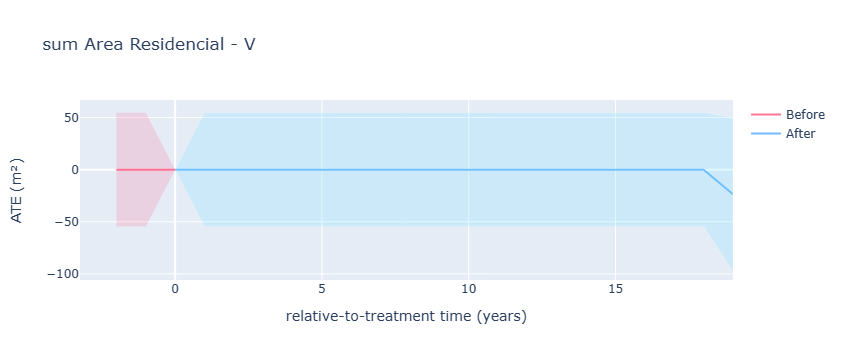

Sacomã


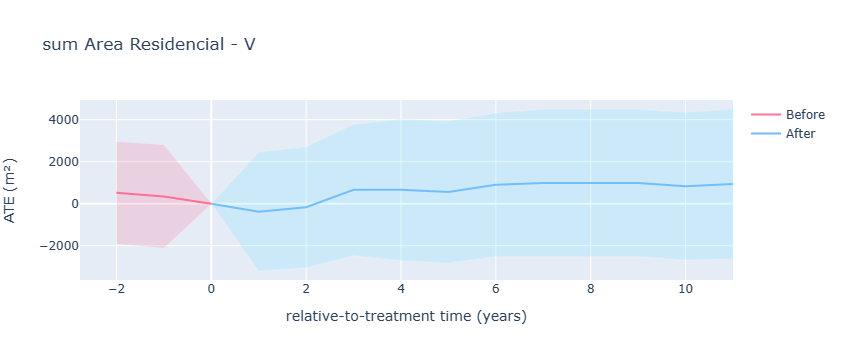

Pinheiros


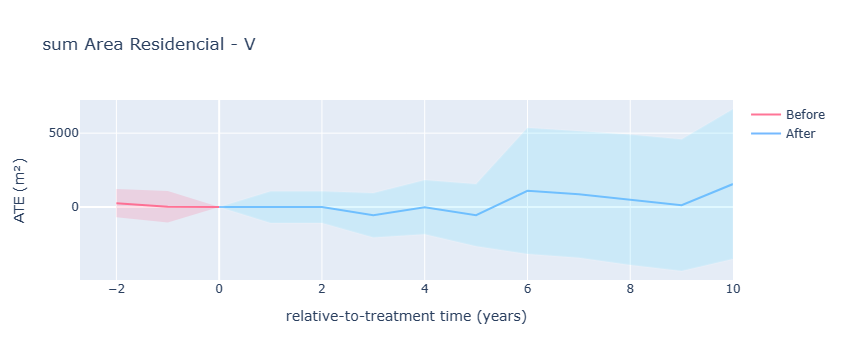

Parada Inglesa


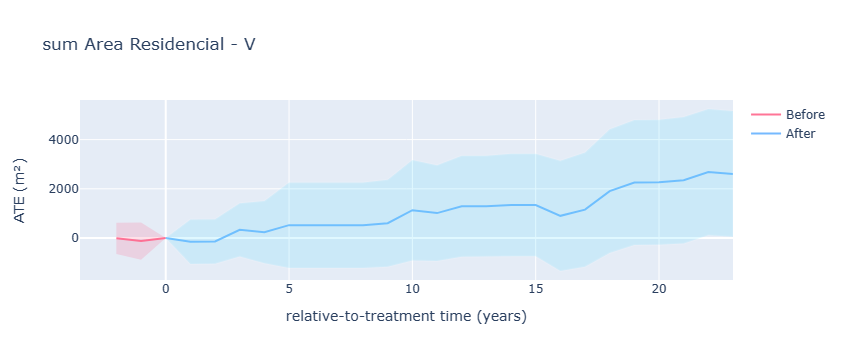

Oscar Freire


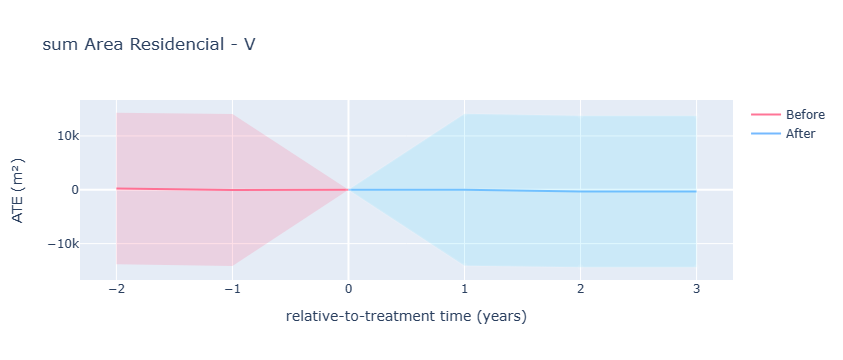

Oratório


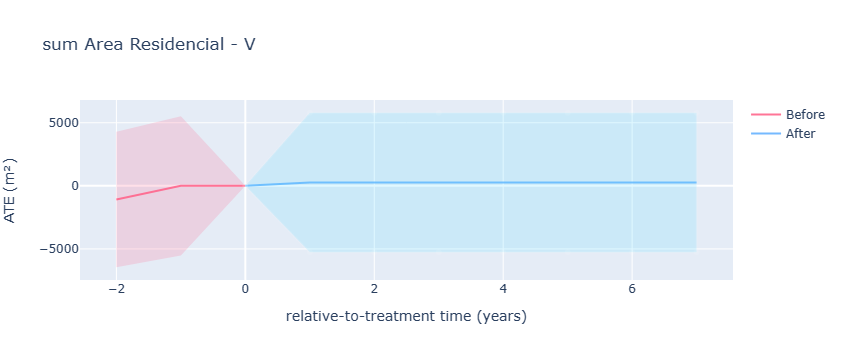

Moema


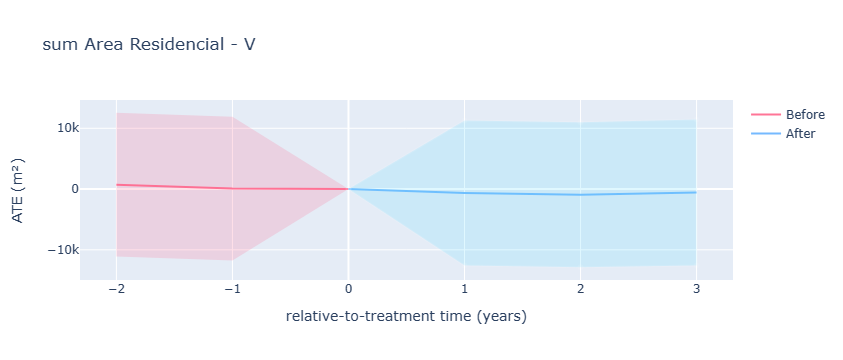

Largo Treze


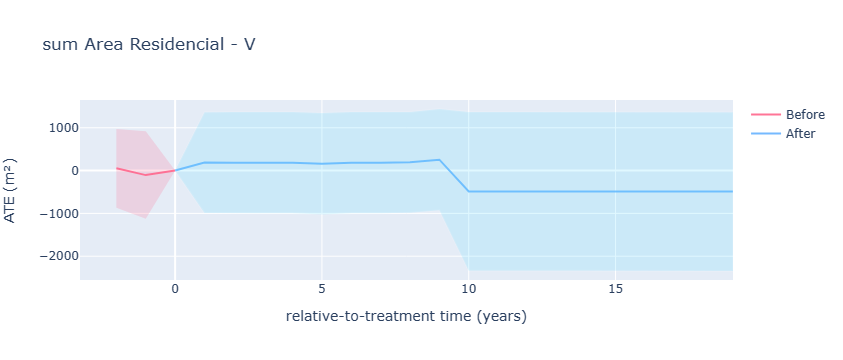

Jardim São Paulo


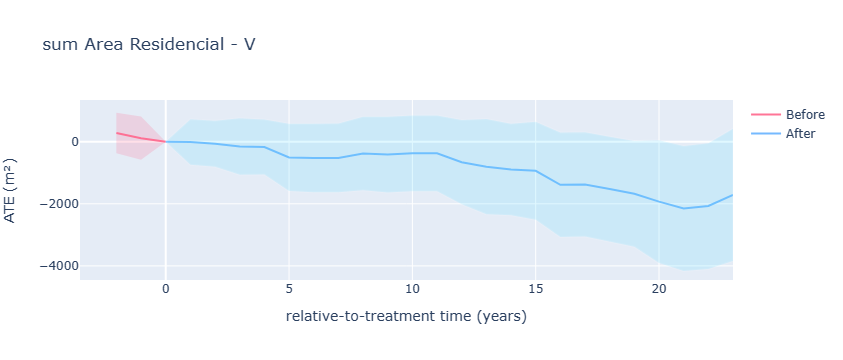

Jardim Planalto


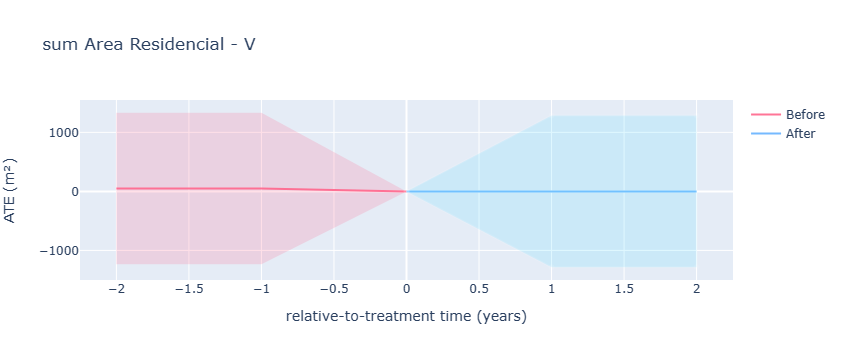

Giovanni Gronchi


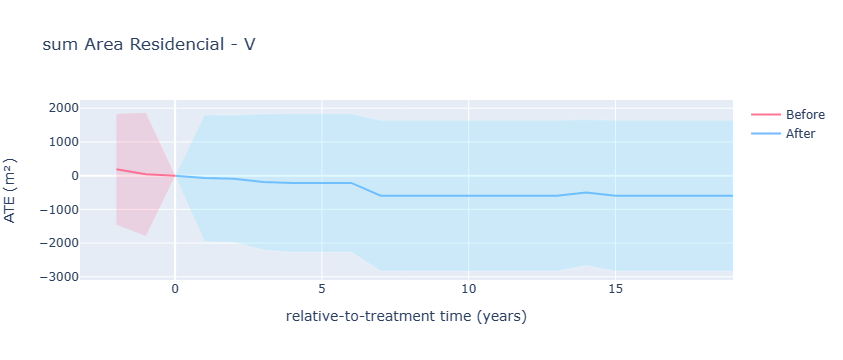

Fradique Coutinho


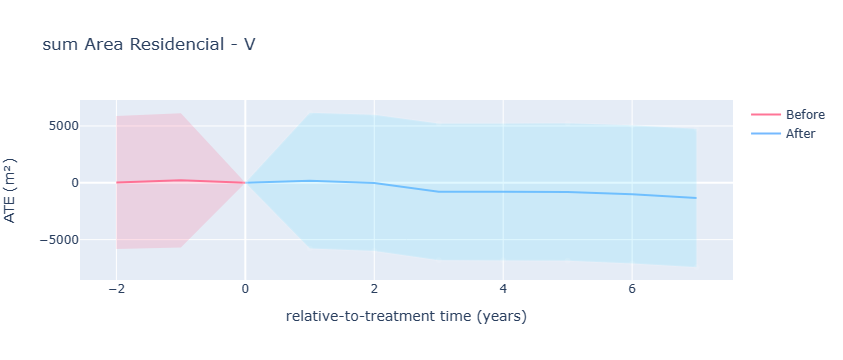

Fazenda da Juta


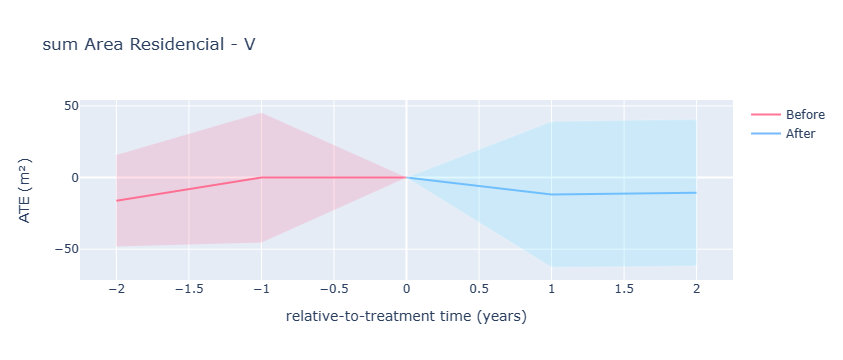

Faria Lima


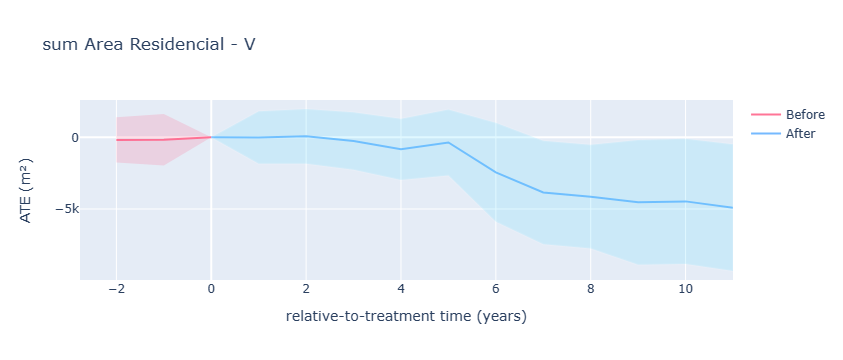

Eucaliptos


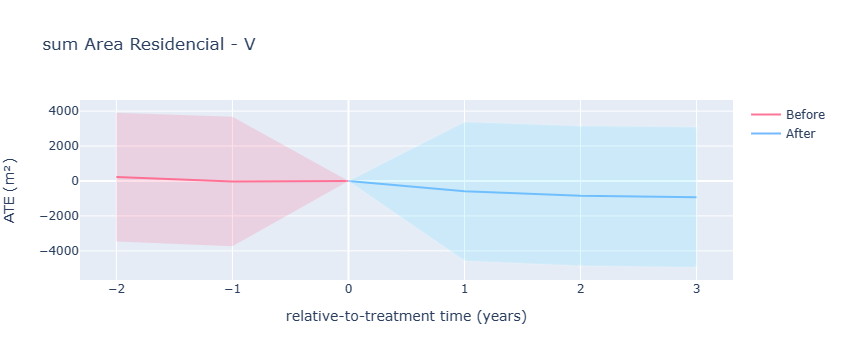

Chácara Klabin


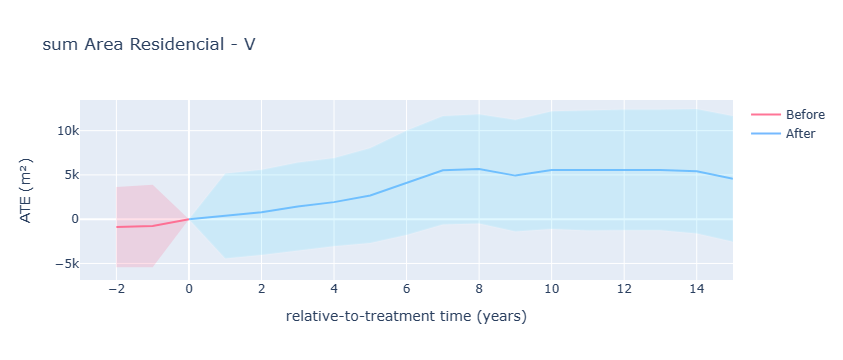

Capão Redondo


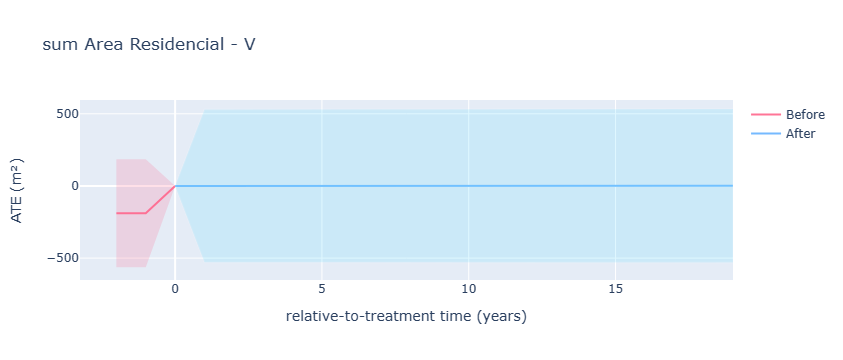

Campo Limpo


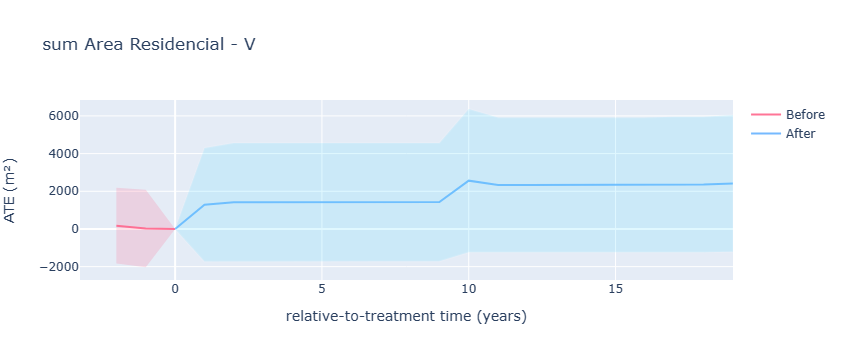

Campo Belo


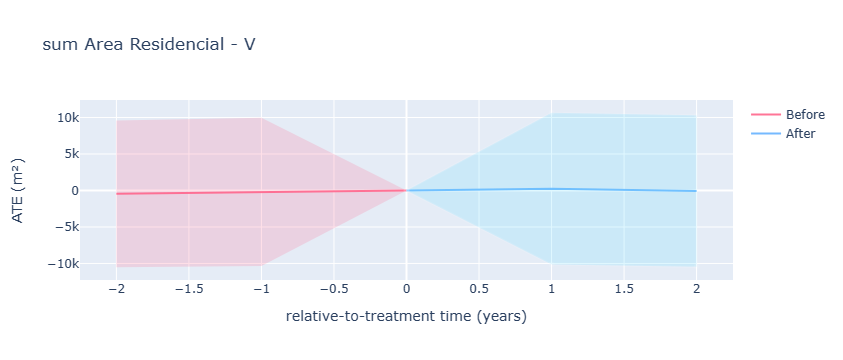

Camilo Haddad


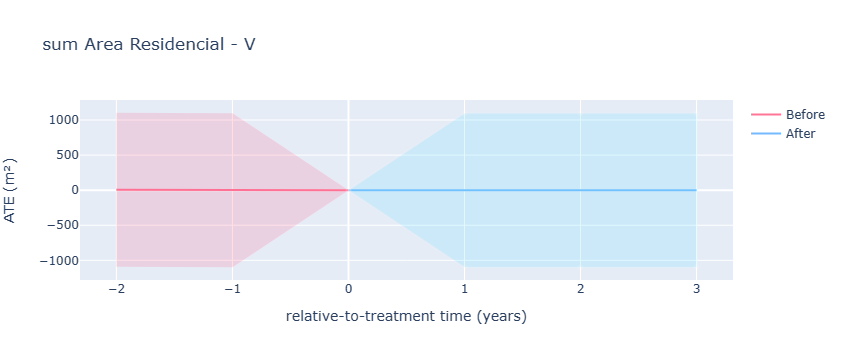

Butantã


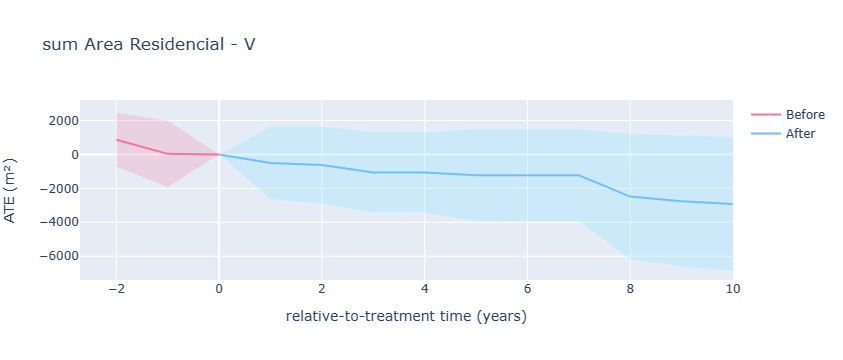

Brooklin


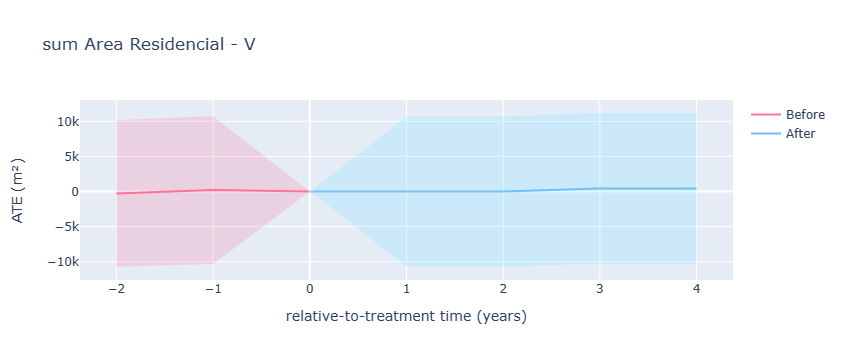

Borba Gato


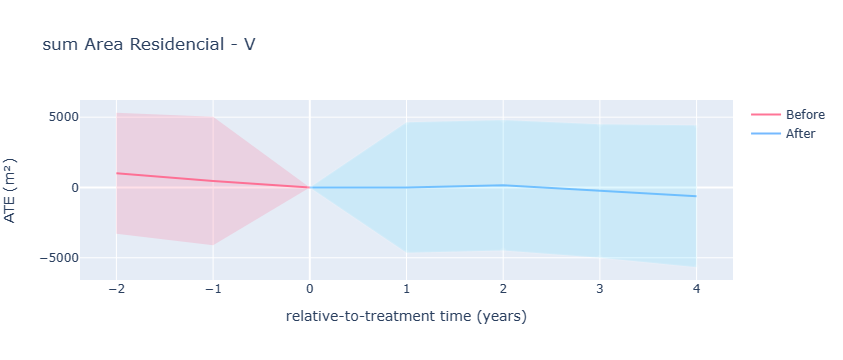

Alto do Ipiranga


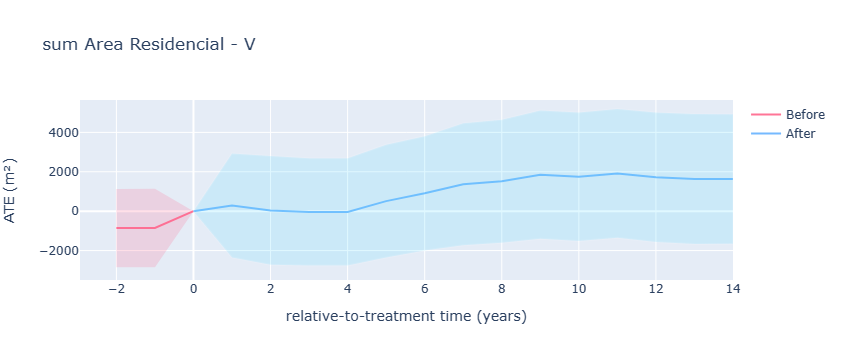

Alto da Boa Vista


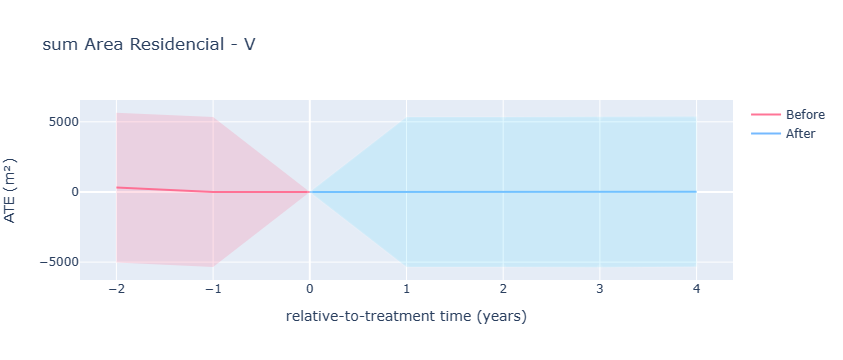

Adolfo Pinheiro


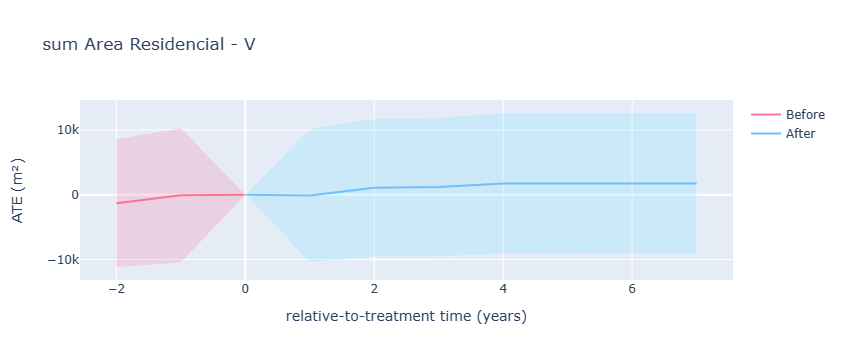

AACD-Servidor


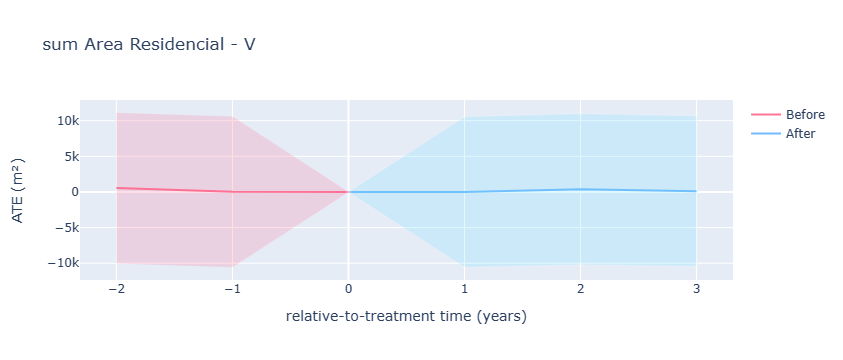

In [224]:
for m in df_results_matching_all.Nome.unique()[::-1]:
    print(m)
    df_results_aux = df_results_matching_all[df_results_matching_all.Nome == m]
    lst_aux_ana = []
    for year in range(-2, df_results_aux.delta.max()):
        lst_aux_ana.append(get_ATE(df_results_aux, delta_ref, year, y).assign(year=year))
    df_plot = pd.concat(lst_aux_ana)
    plot_did(df_plot, delta_ref)

### Callaway & Sant'anna DID

In [234]:
# There isn't a way to run this in Python, so save the dataframe ready to run Callaway did regression

# Copy for another dataframe
df_did_r = df_results_matching_all.copy()

# The R package requires the future year set for the control
df_did_r.loc[df_did_r['T'] == 0, 'ano'] = 2030
# Rename the columns
df_did_r['cohort'] = pd.to_numeric(df_did_r['ano'].values)
df_did_r['time'] = df_did_r['ANO DO EXERCICIO']

In [237]:
# Select the required columns
did_r_cols = [
    'sq', 'cohort', 'time',
    'sum Area Residencial - H', 'sum Area Residencial - V', 'sum Area Comercial',
    'CA', 'QUANTIDADE DE PAVIMENTOS',
    'ANO DO EXERCICIO'
]
# Save the data (General, Central and Peripherical Groups)
df_did_r[did_r_cols].drop_duplicates().to_parquet('df_did_C.parquet')
df_did_r[df_did_r.Nome.isin(metro_alta)][did_r_cols].drop_duplicates().to_parquet('df_did_C_upper.parquet')
df_did_r[df_did_r.Nome.isin(metro_baixa)][did_r_cols].drop_duplicates().to_parquet('df_did_C_lower.parquet')